Mounted at /content/drive
Предупреждение: В некоторых строках установлено более одного флага устройства.
File: data_2024-10-09.parquet
  Sessions with Multi-Device Users: 6434542
  Sessions with Single-Device Users: 3105871


<ipython-input-4-c5848386da52>:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  device_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=140,


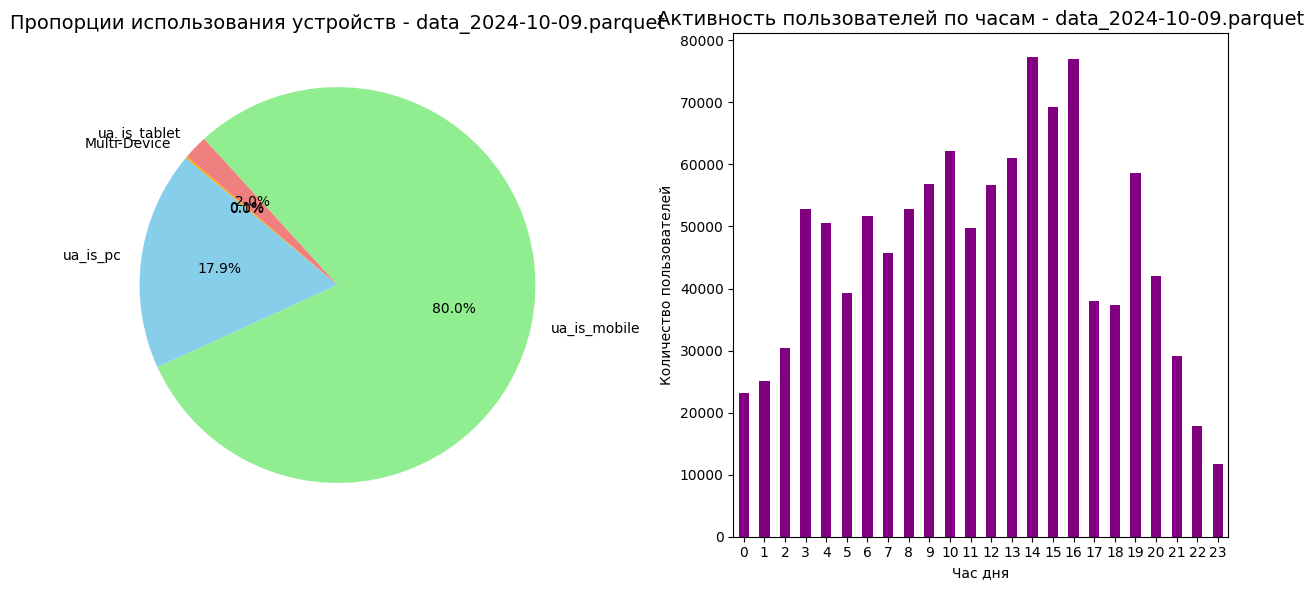

In [4]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

def load_all_data(folder_path):
    """Загрузка всех файлов данных с безопасной обработкой только необходимых столбцов"""
    all_files = sorted(glob.glob(f"{folder_path}/data_2024-10-*.parquet"))
    dfs = []

    # Определяем список необходимых столбцов
    required_columns = ['ts', 'ua_is_tablet', 'ua_is_mobile', 'ua_is_pc', 'randPAS_session_id']

    for file_path in all_files:
        try:
            # Читаем только необходимые столбцы
            df = pd.read_parquet(file_path, columns=required_columns)

            # Обязательные преобразования и создание столбцов
            df['ts'] = pd.to_datetime(df['ts'])
            df['date'] = df['ts'].dt.date
            df['hour'] = df['ts'].dt.hour

            # Заполнение пропущенных значений для столбцов устройств
            for col in ['ua_is_tablet', 'ua_is_mobile', 'ua_is_pc']:
                if col in df.columns:
                    df[col] = df[col].fillna(False)
                else:
                    df[col] = False

            # Обработка столбца randPAS_session_id
            if 'randPASS_session_id' in df.columns:
                df = df.rename(columns={'randPASS_session_id': 'randPAS_session_id'})
            elif 'randPAS_session_id' not in df.columns:
                df['randPAS_session_id'] = None

            dfs.append(df)
            print(f"Успешно загружен: {file_path.split('/')[-1]}")
        except Exception as e:
            print(f"Ошибка при загрузке {file_path}: {e}")

    if not dfs:
        raise ValueError("Не удалось загрузить ни одного файла")
    return pd.concat(dfs, ignore_index=True)


def analyze_device_usage(df, file_name):
    """Анализ использования устройств."""
    required_columns = ['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile', 'randPAS_session_id', 'ts']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: DataFrame должен содержать столбцы {required_columns}.")
        return None

    simultaneous_device_mask = (df[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].sum(axis=1) > 1)
    if simultaneous_device_mask.any():
        print("Предупреждение: В некоторых строках установлено более одного флага устройства.")

    # Get counts of multi and single device users
    multi_device_sessions = df['is_multi_device_session'].sum()
    single_device_sessions = len(df) - multi_device_sessions

    multi_device_users = df.groupby('randPAS_session_id')[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].max()
    multi_device_users['device_count'] = multi_device_users.sum(axis=1)
    multi_device_users = multi_device_users[multi_device_users['device_count'] > 1]
    num_multi_device_users = len(multi_device_users)

    null_device_users = df[df[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].isnull().all(axis=1)]['randPAS_session_id'].nunique()

    single_device_users = df.groupby('randPAS_session_id')[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].max()
    single_device_proportions = single_device_users.sum() / df['randPAS_session_id'].nunique()

    single_device_proportions['Multi-Device'] = num_multi_device_users / df['randPAS_session_id'].nunique()
    single_device_proportions['Null-Device'] = null_device_users / df['randPAS_session_id'].nunique()

    single_device_proportions = single_device_proportions[['ua_is_pc', 'ua_is_mobile', 'ua_is_tablet', 'Multi-Device', 'Null-Device']]

    hourly_data = df.groupby(df['ts'].dt.hour)['randPAS_session_id'].nunique()

    analysis_results = {
        'device_proportions': single_device_proportions,
        'hourly_data': hourly_data,
        'multi_device_sessions': multi_device_sessions,
        'single_device_sessions': single_device_sessions,
        'file_name': file_name
    }

    return analysis_results


def identify_multi_device_users(df):
    """Определение пользователей, использующих несколько устройств в рамках одной сессии."""
    # Проверка необходимых столбцов. Если какие-либо отсутствуют, возвращаем исходный DataFrame без изменений.
    required_columns = ['randPAS_session_id', 'ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: Отсутствуют необходимые столбцы для идентификации многоустройственных пользователей.")
        return df

    # Группировка по ID сессии и подсчет количества уникальных типов устройств
    session_device_counts = df.groupby('randPAS_session_id')[['ua_is_tablet', 'ua_is_pc', 'ua_is_mobile']].sum()
    session_device_counts['device_count'] = session_device_counts.sum(axis=1)

    # Помечаем сессии с несколькими типами устройств
    df['is_multi_device_session'] = df['randPAS_session_id'].isin(session_device_counts[session_device_counts['device_count'] > 1].index)

    return df


def visualize_device_usage(analysis_results):
    """Визуализирует использование устройств."""
    device_proportions = analysis_results['device_proportions']
    hourly_data = analysis_results['hourly_data']
    file_name = analysis_results['file_name']
    multi_device_sessions = analysis_results['multi_device_sessions']
    single_device_sessions = analysis_results['single_device_sessions']

    # Output the device sessions before visuals
    print(f"File: {file_name}")
    print(f"  Sessions with Multi-Device Users: {multi_device_sessions}")
    print(f"  Sessions with Single-Device Users: {single_device_sessions}")

    # 1. Круговая диаграмма пропорций устройств
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    device_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=140,
                              colors=['skyblue', 'lightgreen', 'lightcoral', 'orange', 'gray'])
    plt.title(f'Пропорции использования устройств - {file_name}', fontsize=14)  # Добавляем имя файла в заголовок
    plt.ylabel('')

    # 2. Столбчатая диаграмма активности пользователей по часам
    plt.subplot(1, 2, 2)
    hourly_data.plot(kind='bar', color='purple')
    plt.title(f'Активность пользователей по часам - {file_name}', fontsize=14)  # Добавляем имя файла в заголовок
    plt.xlabel('Час дня')
    plt.ylabel('Количество пользователей')
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()

def load_and_process_file(file_path):
    """Загрузка, обработка и анализ одного файла."""
    # Load only the required columns directly from parquet
    required_columns = ['ts', 'ua_is_tablet', 'ua_is_mobile', 'ua_is_pc', 'randPAS_session_id']

    try:
        df = pd.read_parquet(file_path, columns=required_columns)
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден: {file_path}")
        return
    except Exception as e:
        print(f"Ошибка при загрузке {file_path}: {e}")
        return

    # Обязательные преобразования и создание столбцов
    df['ts'] = pd.to_datetime(df['ts'])
    df['date'] = df['ts'].dt.date
    df['hour'] = df['ts'].dt.hour

    # Заполнение пропущенных значений для столбцов устройств
    for col in ['ua_is_tablet', 'ua_is_mobile', 'ua_is_pc']:
        if col in df.columns:
            df[col] = df[col].fillna(False)
        else:
            df[col] = False

    # Обработка столбца randPAS_session_id
    if 'randPASS_session_id' in df.columns:
        df = df.rename(columns={'randPASS_session_id': 'randPAS_session_id'})
    elif 'randPAS_session_id' not in df.columns:
        df['randPAS_session_id'] = None

    df = identify_multi_device_users(df)  # Определение многоустройственных пользователей
    analysis_results = analyze_device_usage(df, file_path.split('/')[-1])

    if analysis_results is not None:
        visualize_device_usage(analysis_results)

def main(file_path):
    """Основная функция."""
    load_and_process_file(file_path)

# Пример использования (специфично для Colab)
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/dataset/data_2024-10-09.parquet'
main(file_path)